In [16]:
import numpy as np
from scipy.fftpack import dct, idct
from PIL import Image
import json
import matplotlib.pyplot as plt

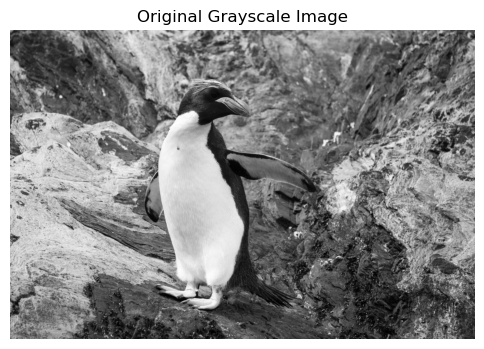

In [17]:
image_path = 'images/penguin.png'
image = Image.open(image_path).convert('L')

image.save("images/penguin_original.jpg", "JPEG")

image_data = np.array(image)

plt.figure(figsize=(6, 6))
plt.title("Original Grayscale Image")
plt.imshow(image_data, cmap='gray')
plt.axis('off')
plt.show()

The pad_image() function was added for images whose **dimensions are not perfectly divisible by 8**. The motivation was from the experimenatal phase where we passed such images and the code was not able to process such images.

In [ ]:
def pad_image(image, block_size=8):
    h, w = image.shape
    pad_h = (block_size - h % block_size) % block_size
    pad_w = (block_size - w % block_size) % block_size
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    return padded_image, padded_image.shape

## Compression steps

The split_into_blocks() function will split the entire image into smaller **non-overlapping** 8x8 blocks.

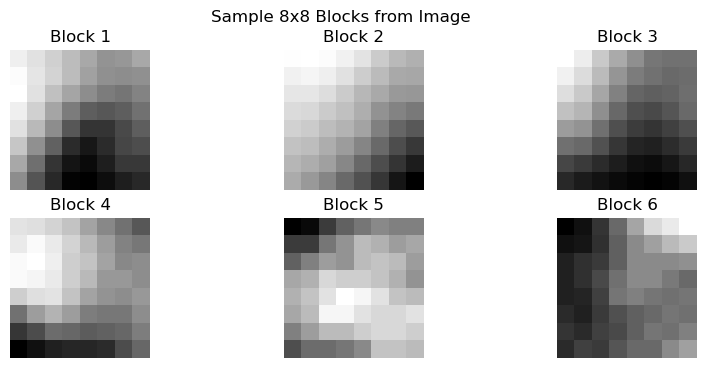

In [18]:
def split_into_blocks(channel, block_size=8):
    h, w = channel.shape
    blocks = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = channel[i:i+block_size, j:j+block_size]
            if block.shape == (block_size, block_size):
                blocks.append(block)
    return np.array(blocks)

padded_image, padded_shape = pad_image(image_data)
blocks = split_into_blocks(padded_image)

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(blocks[i], cmap='gray')
    plt.title(f"Block {i+1}")
    plt.axis('off')
plt.suptitle("Sample 8x8 Blocks from Image")
plt.show()

The apply_dct() function will apply Discrete Cosine Transformation (DCT) to each of the 8x8 image blocks, thereby transforming the image from spatial to frequency domain.
- Each block is being transformed using dct(block.T, norm='ortho').T, which performs 2D DCT by applying to the **rows first, and thn to the columns**.
- The **norm='ortho'** normalizes the DCT, ensuring the energy is evenly distributed.
- The result is a **8x8 block containing frequency coefficients**, where the lower frequencies are concentrated in the top-left corner.

In [ ]:
def apply_dct(blocks):
    dct_blocks = []
    for block in blocks:
        dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
        dct_blocks.append(dct_block)
    return np.array(dct_blocks)

dct_blocks = apply_dct(blocks)

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(dct_blocks[i], cmap='gray')
    plt.title(f"DCT Block {i+1}")
    plt.axis('off')
plt.suptitle("DCT of Sample 8x8 Blocks")
plt.show()

The quantize() function is applied to the block of DCT coefficients, and is a **lossy** procedure.

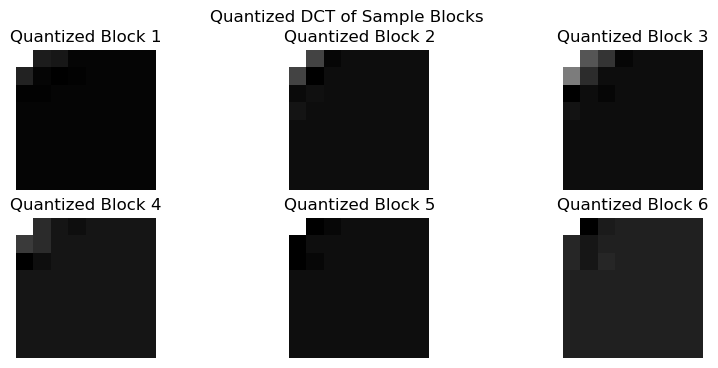

In [19]:
# Quantization matrix for grayscale images
quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

def quantize(blocks, quant_matrix):
    quantized_blocks = []
    for block in blocks:
        quantized_block = np.round(block / quant_matrix).astype(int)
        quantized_blocks.append(quantized_block)
    return np.array(quantized_blocks)

quantized_blocks = quantize(dct_blocks, quant_matrix)

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(quantized_blocks[i], cmap='gray')
    plt.title(f"Quantized Block {i+1}")
    plt.axis('off')
plt.suptitle("Quantized DCT of Sample Blocks")
plt.show()

The zigzag_order() function arranges the Quantized DCT Coefficients in a **1D order**, with lower indices occupied by lower frequency coeeficients.

Prepares the data for Run-Length Encoding (RLE) and Huffman encoding in standard JPEG compression, making it easier to compress long runs of zeros.

In [20]:
def zigzag_order(block):
    zigzag_pattern = np.array([
        [0, 1, 5, 6, 14, 15, 27, 28],
        [2, 4, 7, 13, 16, 26, 29, 42],
        [3, 8, 12, 17, 25, 30, 41, 43],
        [9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]
    ]).flatten()
    return block.flatten()[zigzag_pattern]

zigzag_blocks = [zigzag_order(block) for block in quantized_blocks]

print("Sample Zigzag Order of Quantized Coefficients:")
print(zigzag_blocks[0])

Sample Zigzag Order of Quantized Coefficients:
[87  8  0  0  0  0  0  0  6  0  0  0 -1  0  0  0  0 10  0 -1  0  0  0  0
  0 -1  0  0  0  0  0  0 -2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Decompression steps

The inverse_quantize() function **scales** the Quantized DCT Coefficients back up via multiplication.

In [ ]:
def inverse_quantize(blocks, quant_matrix):
    return np.array([block * quant_matrix for block in blocks])

dequantized_blocks = inverse_quantize(quantized_blocks, quant_matrix)



The apply_idct() function transforms the frequency domain data **back to spatial domain** pixel values.

In [ ]:
def apply_idct(blocks):
    return np.array([idct(idct(block.T, norm='ortho').T, norm='ortho') for block in blocks])

idct_blocks = apply_idct(dequantized_blocks)



The reconstruct_image_from blocks() function will reaasemble the 8x8 blocks into the final image.
- padded_shape will be passed as image_shape argument to avoid partial blocks

In [8]:
def reconstruct_image_from_blocks(blocks, image_shape, block_size=8):
    h, w = image_shape
    image = np.zeros((h, w))
    block_index = 0
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            image[i:i+block_size, j:j+block_size] = blocks[block_index]
            block_index += 1
    return image

reconstructed_image = reconstruct_image_from_blocks(idct_blocks, padded_shape)



In [9]:
from PIL import Image

# To ensure pixel values are in the correct range (0 to 255)
reconstructed_image_clipped = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

# To convert the array to an Image object and save it as a JPEG
reconstructed_img = Image.fromarray(reconstructed_image_clipped, mode='L')
reconstructed_img.save("images/reconstructed_image.jpg", "JPEG")
print("Reconstructed image saved as reconstructed_image.jpg")

Reconstructed image saved as reconstructed_image.jpg


In [10]:
import os

original_size = os.path.getsize("images/penguin.png")
print(f"Original Image Size: {original_size} bytes")

compressed_size = os.path.getsize("images/reconstructed_image.jpg")
print(f"Compressed Image Size: {compressed_size} bytes")

space_saved = original_size - compressed_size
compression_ratio = original_size / compressed_size
space_saved_percentage = (space_saved / original_size) * 100

print(f"Space Saved: {space_saved} bytes ({space_saved_percentage:.2f}%)")
print(f"Compression Ratio: {compression_ratio:.2f}")

Original Image Size: 5290002 bytes
Compressed Image Size: 409353 bytes
Space Saved: 4880649 bytes (92.26%)
Compression Ratio: 12.92
